In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 

import sklearn.metrics 

import matplotlib.pyplot as plt

def roc_auc(pred, act, plot=True, label = "curve"):
    prob = pred/pred.max() #normalize
    fpr, tpr, threshold = sklearn.metrics.roc_curve(act, prob, drop_intermediate=True)    
    auc = sklearn.metrics.auc(fpr, tpr)

    if plot:
        plt.scatter(x=fpr, y=tpr, color='navy')
        rcolor = tuple(np.random.rand(3,1)[:,0])
        plt.plot(fpr, tpr, c=rcolor, lw=2, label=label + ' (AUC = %0.3f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    return auc

### kaggle
datain_dir = '.diabetes/'
dataout_dir = ''

In [2]:
df_raw_all = pd.read_csv('diabetic_data.csv') 
df_raw = df_raw_all.sample(10000)
df_raw = df_raw.replace('?', np.nan) 
df_raw.shape

(10000, 50)

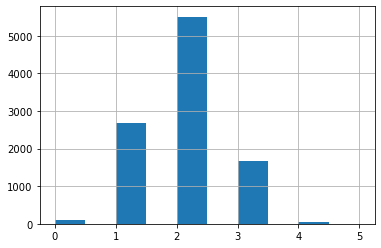

In [3]:
pt_sparsity = df_raw.isnull().apply(sum, axis=1)
%matplotlib inline
myhist = pt_sparsity.hist()

In [5]:
col_data = df_raw.apply(lambda s: set(s.unique()), axis=0).to_frame('uni_val')
col_data['nan_rat'] = df_raw.isnull().sum(axis=0)/len(df_raw)
col_data['n_uni_vals'] = col_data.uni_val.apply(len)
col_data['uni_vals_str'] = col_data[col_data.n_uni_vals<2000].uni_val.astype(str)
col_data = col_data.drop('uni_val', axis=1)
col_data['var_type'] = np.nan
col_data.to_csv("columns_raw.csv")

In [10]:
col_data = pd.read_csv("columns.csv", index_col=0)
col_data.sample(10)

,nan_rat,n_uni_vals,uni_vals_str,var_type,comment
metformin,0.0000,4,"{'Steady', 'Up', 'No', 'Down'}",cat,NaN
diabetesMed,0.0000,2,"{'No', 'Yes'}",cat,NaN
weight,0.9673,8,"{nan, '[50-75)', '[75-100)', '[150-175)', '[10...",drop,too many missing values
change,0.0000,2,"{'No', 'Ch'}",cat,NaN
nateglinide,0.0000,4,"{'Steady', 'Up', 'No', 'Down'}",cat,NaN
tolbutamide,0.0000,2,"{'Steady', 'No'}",cat,NaN
medical_specialty,0.4941,55,"{nan, 'Surgery-Plastic', 'Pulmonology', 'Osteo...",drop,eventually we will include top specialties
pioglitazone,0.0000,4,"{'Steady', 'Up', 'No', 'Down'}",cat,NaN
glyburide,0.0000,4,"{'Steady', 'Up', 'No', 'Down'}",cat,NaN
admission_source_id,0.0000,13,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 17, 20, 22}",cat,NaN


In [11]:
#TODO recapture medical specialty
spec_counts = df_raw.medical_specialty.value_counts()
spec_counts.head(5).to_frame('num patients')

,num patients
InternalMedicine,1470
Emergency/Trauma,751
Family/GeneralPractice,744
Cardiology,525
Surgery-General,277


In [13]:
spec_thresh = 5
for (spec, count) in spec_counts.head(spec_thresh).iteritems():
    new_col = 'spec_' + str(spec)
    df_raw[new_col] = (df_raw.medical_specialty == spec)
    
df_raw.filter(regex='spec').sample(10)

,medical_specialty,spec_InternalMedicine,spec_Emergency/Trauma,spec_Family/GeneralPractice,spec_Cardiology,spec_Surgery-General
30000,Surgery-General,False,False,False,False,True
43971,Family/GeneralPractice,False,False,True,False,False
31867,InternalMedicine,True,False,False,False,False
747,NaN,False,False,False,False,False
91071,NaN,False,False,False,False,False
22276,NaN,False,False,False,False,False
40231,Cardiology,False,False,False,True,False
86424,InternalMedicine,True,False,False,False,False
59483,NaN,False,False,False,False,False
56499,Radiologist,False,False,False,False,False


In [14]:
diag_counts = (df_raw.diag_1.value_counts() + df_raw.diag_2.value_counts() + df_raw.diag_3.value_counts()).sort_values(ascending=False)
diag_counts.head(10).to_frame('num patients w diag')

,num patients w diag
250,1794.0
428,1755.0
276,1369.0
414,1253.0
401,1196.0
427,1174.0
599,680.0
403,579.0
496,574.0
486,567.0


In [15]:
diag_thresh = 10
for (icd9, count) in diag_counts.head(diag_thresh).iteritems():
    new_col = 'diag_' + str(icd9)
    df_raw[new_col] = (df_raw.diag_1 == icd9)|(df_raw.diag_2 == icd9)|(df_raw.diag_3 == icd9)
    
df_raw.filter(regex='diag_').sample(10)

,diag_1,diag_2,diag_3,diag_250,diag_428,diag_276,diag_414,diag_401,diag_427,diag_599,diag_403,diag_496,diag_486
34430,786,250,401,True,False,False,False,True,False,False,False,False,False
66558,726,682,287,False,False,False,False,False,False,False,False,False,False
64050,784,787,873,False,False,False,False,False,False,False,False,False,False
45295,410,428,427,False,True,False,False,False,True,False,False,False,False
71149,250.13,38,995,False,False,False,False,False,False,False,False,False,False
43002,599,276,785,False,False,True,False,False,False,True,False,False,False
69201,715,428,584,False,True,False,False,False,False,False,False,False,False
88478,250,496,272,True,False,False,False,False,False,False,False,True,False
60761,427,427,621,False,False,False,False,False,True,False,False,False,False
93765,493,799,250.8,False,False,False,False,False,False,False,False,False,False


In [16]:
df_raw.age.sample(10)

60455    [50-60)
54945    [70-80)
64311    [70-80)
29066    [80-90)
8934     [60-70)
43461    [60-70)
62265    [70-80)
81800    [50-60)
61059    [60-70)
77450    [60-70)
Name: age, dtype: object

In [17]:
df_raw2 = pd.DataFrame(df_raw, copy=True) #preserve df_raw so I can rerun this step
df_raw2['age'] = df_raw2.age.str.extract('(\d+)-\d+')

to_drop = col_data[col_data.var_type.str.contains('drop')].index
df_raw2.drop(to_drop, axis=1, inplace=True)

#break out categorical variables into binaries
cat_cols = col_data[col_data.var_type.str.contains('cat')].index
df_raw2 = pd.get_dummies(df_raw2, columns=cat_cols)

#dropping these leaves up with one binary variable, ideal for simplicity
df_raw2.drop(['readmitted_<30','readmitted_>30'], axis=1, inplace=True)

#cleaning up outcome variable
df_raw2['is_readmitted'] = (df_raw2.readmitted_NO == 0)
df_raw2.drop('readmitted_NO', axis=1, inplace=True)

#ta daaaaaah, the data is ready to go
df = pd.DataFrame(df_raw2)
df.shape

(10000, 155)

In [18]:
df.age.sample(10)

69477    30
59673    70
53257    80
4107     50
78920    60
48413    30
31213    40
89013    50
71640    70
15905    50
Name: age, dtype: object

In [19]:
df.sample(15).sample(7, axis=1)

,discharge_disposition_id_6,race_Other,admission_type_id_1,admission_type_id_3,metformin_Up,payer_code_SI,payer_code_CH
33478,1,0,0,0,0,0,0
62307,1,0,0,0,0,0,0
28152,0,0,0,0,0,0,0
2646,0,0,1,0,0,0,0
32269,0,0,1,0,0,0,0
69676,0,0,1,0,0,0,0
8500,1,0,0,1,0,0,0
83757,1,0,0,1,0,0,0
62656,1,0,1,0,0,0,0
74508,1,0,1,0,0,0,0


In [20]:
df.is_readmitted.value_counts()

False    5387
True     4613
Name: is_readmitted, dtype: int64

In [21]:
#partition training and test data, one balanced training set, all remaining for testing 
outcome_column = 'is_readmitted' 

#Imputing with outlying value since we are focusing on tree based methods
dff = df.fillna(-9999) 

#%% Split data for validation
X = dff.drop(outcome_column, axis=1) 
y = dff[outcome_column] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [22]:
rfc_rfe = RandomForestClassifier(n_estimators = 100)
#This step takes a while to run...
rfe = RFECV(estimator=rfc_rfe, cv=5, verbose=0, n_jobs=10)
rfe.fit(X_train, y_train)

RFECV(cv=5, estimator=RandomForestClassifier(), n_jobs=10)

In [23]:
feat_ranks = pd.Series(index=X.columns, data=rfe.ranking_)
rf_feats = feat_ranks[feat_ranks==1].index
len(feat_ranks)

154

In [24]:
X_test_red = rfe.transform(X_test)
X_train_red = rfe.transform(X_train)

rfc = rfe.estimator_

feat_imp = pd.Series(index=rf_feats, data=rfc.feature_importances_)
feat_imp.sort_values(ascending=False).head(20)

num_lab_procedures             0.078561
num_medications                0.070619
number_inpatient               0.056421
time_in_hospital               0.052199
age                            0.044607
number_diagnoses               0.038889
num_procedures                 0.037706
number_outpatient              0.020859
number_emergency               0.018161
payer_code_MC                  0.015810
discharge_disposition_id_1     0.014818
gender_Male                    0.013877
gender_Female                  0.013663
discharge_disposition_id_11    0.012711
insulin_Steady                 0.011769
diag_428                       0.011609
admission_type_id_1            0.011572
race_Caucasian                 0.011326
spec_InternalMedicine          0.010866
admission_source_id_7          0.010830
dtype: float64

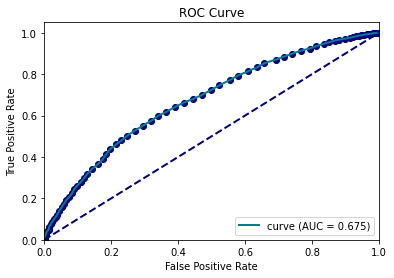

0.6747298431969658

In [25]:
#%% assess accuracy
pred = rfc.predict_proba(X_test_red)[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, pred, drop_intermediate=True)    
df_res = pd.DataFrame(data={'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
df_res = df_res[['threshold','fpr','tpr']]
sklearn.metrics.auc(fpr, tpr)
t=y.value_counts()[1]/y.value_counts().sum()
sklearn.metrics.f1_score(y_test, pred>t)
sklearn.metrics.accuracy_score(y_test, pred>t)

roc_auc(pred, y_test)

In [26]:
#TODO - visualize accuracy metrics based on threshold
pd.options.mode.chained_assignment = None
pred = rfc.predict_proba(X_test_red)[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, pred, drop_intermediate=True)    
df_res = pd.DataFrame(data={'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
df_res = df_res[['threshold','fpr','tpr']]
sklearn.metrics.auc(fpr, tpr)

0.6747298431969658

In [27]:
df_res['accuracy'] = df_res.threshold.apply(lambda t: sklearn.metrics.accuracy_score(y_test, pred>t))
df_res['precision'] = df_res.threshold.apply(lambda t: sklearn.metrics.precision_score(y_test, pred>t))
df_res['recall'] = df_res.threshold.apply(lambda t: sklearn.metrics.recall_score(y_test, pred>t))
df_res['f1'] = df_res.threshold.apply(lambda t: sklearn.metrics.f1_score(y_test, pred>t))
df_res['specificity'] = df_res.fpr.apply(lambda fpr: 1-fpr)

pt_opt = df_res[df_res.f1 == df_res.f1.max()].iloc[0]
pt_opt

C:\Users\const\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


threshold      0.340000
fpr            0.691557
tpr            0.870236
accuracy       0.581000
precision      0.532051
recall         0.853105
f1             0.655371
specificity    0.308443
Name: 58, dtype: float64

<AxesSubplot:xlabel='threshold'>

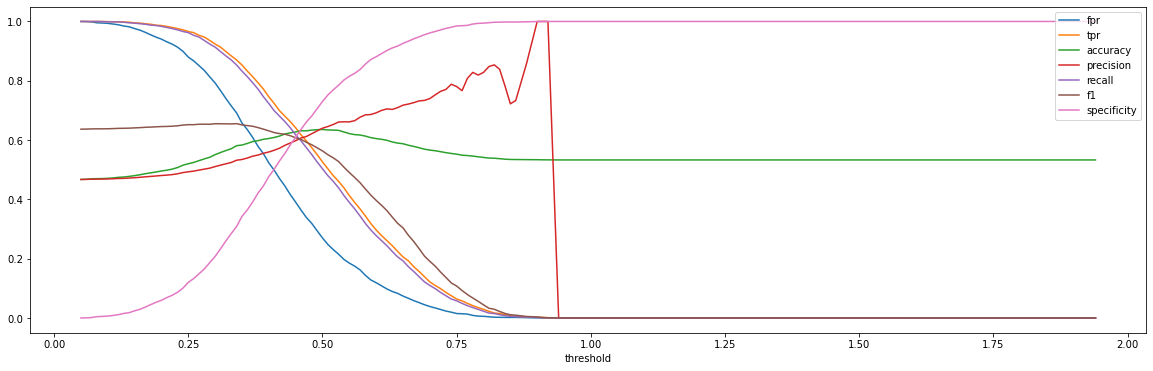

In [28]:
plt.rcParams["figure.figsize"] = (20,6)
df_res.plot(x='threshold')

In [31]:
from six import StringIO  

dtc = DecisionTreeClassifier(min_samples_leaf=0.125, min_samples_split=0.125)
dtc.fit(X_train_red, y_train)
from sklearn import tree

In [35]:
from IPython.display import Image
from subprocess import check_call
tree.export_graphviz(dtc, out_file="tree.dot", feature_names=rf_feats, proportion=True)
check_call(['dot','-Tpng','tree.dot','-o','tree.png'])
Image(filename='tree.png')

FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable